In [20]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.linalg import lstsq
from sklearn.model_selection import train_test_split
import cvxpy as cp

In [21]:
def solve_inner(C, q_hp, delta_T_i, delta_T_a, q_solar, SPC_sum, DHW_sum, 
                Q_DHW_estimate, q_max, delta_t):
    """Solve inner CVXPY problem for a given C and return parameters + metrics."""
    N = len(delta_T_i)
    Q_sc = np.sum(q_hp) - Q_DHW_estimate - SPC_sum + DHW_sum

    # CVXPY variables
    a   = cp.Variable(pos=True)
    w_s = cp.Variable(nonneg=True)
    #w_w = cp.Variable(nonneg=True)
    w   = cp.Variable()
    e   = cp.Variable()
    z   = cp.Variable(N, nonneg=True)
    u   = cp.Variable(N)
    q_hat = cp.Variable(N)

    # Expression
    expr = (delta_T_a * a * delta_t + q_hat + w_s * q_solar + w * np.ones(N)*
            delta_t)

    # Constraints
    constraints = [
        cp.sum(q_hat) - Q_sc == e,
        delta_T_i + u == expr / C,
        q_hat >= 0,
        q_hat <= q_hp + z,
        q_hat <= q_max ,
        a >= 1/25
    ]

    # Objective weights
    phi_e = 0.1
    phi_z = 0.001
    phi_u = 2000
    objective = cp.Minimize(
        phi_e * e**2 +
        phi_z * cp.norm2(z) +
        phi_u * cp.norm2(u) +
        phi_z * cp.maximum(0, -(q_hat+z)).sum()
    )

    prob = cp.Problem(objective, constraints)
    _ = prob.solve(solver=cp.GUROBI, verbose=False)

    # Extract values
    R_a = 1 / a.value
    ws_val = w_s.value
    #ww_val = w_w.value
    w_val = w.value
    q_hat_val = q_hat.value


    # RMSE for dTi (u)
    rmse_dTi = np.sqrt(np.mean(u.value**2))

    # RMSE for q_hat vs q_hp
    rmse_q = np.sqrt(np.mean((q_hat.value - q_hp * delta_t)**2))
    
    return R_a, ws_val, w_val, rmse_q, rmse_dTi, q_hat_val, Q_sc

In [22]:
df_data = pd.read_parquet("training_data/initial_dataset.parquet")
df_train_detached = pd.read_parquet(
    "training_data/data_detached_with_weather.parquet")
type(df_data)
type(df_train_detached)
df_train_detached

,Property_ID,Timestamp,half-hour,Boiler_Energy_Output,Circulation_Pump_Energy_Consumed,Heat_Pump_Energy_Output,Whole_System_Energy_Consumed,External_Air_Temperature,Heat_Pump_Heating_Flow_Temperature,Heat_Pump_Return_Temperature,...,Postcode,Time,Temperature,FeelsLike,Humidity,Dew,Precipitation,SolarRadiation,SolarEnergy,Windspeed
0,EOH0279,2020-10-26 00:00:00,00:00:00,NaN,0.000,0.000,0.008,9.38,23.14,23.35,...,EH22,00:00:00,8.90,6.10,79.75,5.6,0.154,0.0,0.0,19.30
1,EOH1703,2020-10-26 00:00:00,00:00:00,NaN,0.013,0.242,0.078,7.08,25.04,24.04,...,NE15,00:00:00,7.00,4.30,81.71,4.1,0.170,0.0,0.0,14.30
2,EOH1703,2020-10-26 00:30:00,00:30:00,NaN,0.029,0.622,0.212,6.83,25.43,24.23,...,NE15,00:30:00,6.95,4.05,81.93,4.1,0.085,0.0,0.0,15.85
3,EOH0279,2020-10-26 00:30:00,00:30:00,NaN,0.000,0.000,0.019,9.33,22.54,22.80,...,EH22,00:30:00,8.85,6.30,79.94,5.6,0.077,0.0,0.0,17.00
4,EOH0279,2020-10-26 01:00:00,01:00:00,NaN,0.000,2.730,0.967,9.21,35.27,30.93,...,EH22,01:00:00,8.80,6.50,80.13,5.6,0.000,0.0,0.0,14.70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
505054,EOH3154,2023-09-29 00:00:00,00:00:00,NaN,0.000,44801.768,14989.282,12.44,18.87,50.46,...,EH15,00:00:00,12.80,12.80,90.62,11.3,0.333,0.0,0.0,16.00
505055,EOH1637,2023-09-29 00:00:00,00:00:00,NaN,203.311,43996.381,13830.005,12.17,16.70,16.53,...,PH7,00:00:00,13.20,13.20,86.43,11.0,0.004,0.0,0.0,17.00
505056,EOH2329,2023-09-29 00:00:00,00:00:00,NaN,31.139,14128.100,5775.602,12.44,24.80,26.31,...,EH4,00:00:00,12.90,12.90,90.75,11.4,0.378,0.0,0.0,15.00
505057,EOH2675,2023-09-29 00:00:00,00:00:00,NaN,212.928,59675.471,19247.887,12.44,14.82,14.85,...,EH9,00:00:00,13.00,13.00,93.04,11.9,0.024,0.0,0.0,24.30


In [23]:
unique_ids = df_train_detached["Property_ID"].unique()
unique_ids

array(['EOH0279', 'EOH1703', 'EOH1485', 'EOH0546', 'EOH2329', 'EOH2675',
       'EOH3154', 'EOH0413', 'EOH1637', 'EOH3196'], dtype=object)

In [24]:
df_house = pd.read_csv('training_data/home_characteristics.csv')

# List of columns to check for missingness
cols = [
    "Bedrooms", "Floor_Height", "Habitable_Rooms", "House_Age",
    "House_Form", "No_Storeys", "No_Underfloor",
    "Total_Floor_Area", "Wall_Type", "MCS_DHWAnnual","HP_Size_kW"
]

df_house_train = {}
for id_use in unique_ids:
    df_house_train[id_use] = df_house[df_house["Property_ID"] == id_use]
    
J = df_house_train[id_use].MCS_DHWAnnual.to_numpy()
k = df_house_train[id_use].Wall_Type.to_string()
print(k)

76    Cavity_No_insulation


In [25]:
trained_params = pd.DataFrame(index = ["Floor Area","No_Storeys","Wall_Type",
                                       "C","R_a","w_s","w_w","w",
                                       "Q_hat","Q_sc","rmse_dTi",
                                       "rmse_q_hp"])


df_single = df_train_detached[df_train_detached["Property_ID"] == id_use].copy()
df_single = df_single.set_index('Timestamp')

#time range
t_start = pd.to_datetime("2022 01 01 00:00:00")
t_mid_end = pd.to_datetime("2022 5 30 23:59:59")
t_mid_start = pd.to_datetime("2022 08 31 00:00:00")
t_end = pd.to_datetime("2022 12 31 23:59:59")
df_index = df_single[df_single.index>=t_start]
df_index = df_index[df_index.index<=t_end]
df_index = df_index[
     (df_index.index<=t_mid_end) | (df_index.index>=t_mid_start)]

# Create time index for q_hat arrays
time_index = df_index.index[:-1]
df_q_id = pd.DataFrame(index=time_index)


for id_use in unique_ids:
    wall = df_house_train[id_use].Wall_Type.to_string()
    storeys = df_house_train[id_use].No_Storeys.to_string()
    floor_area = df_house_train[id_use].Total_Floor_Area.to_string()
    
    df_single = df_train_detached[df_train_detached["Property_ID"] == id_use].copy()
    
    #re-adjust Heat Pump Diff and add temp differences
    df_single["Heat_Pump_Energy_Output_Diff"] = df_single["Heat_Pump_Energy_Output"].diff()
    df_single["Internal_Temperature_Diff"] = df_single["Internal_Air_Temperature"].diff()
    df_single["Internal_Ambient_Temperature_Diff"] = \
        (df_single["External_Air_Temperature"] - 
         df_single["Internal_Air_Temperature"])
         
    
    
    # 1. Drop columns with almost all missing data (e.g., more than 90% missing)
    threshold = 0.90 * len(df_single)
    df_single_cleaned = df_single.dropna(axis=1, thresh=threshold)
    #print("Columns dropped due to high missing values:")
    #print(df_single.columns.difference(df_single_cleaned.columns).tolist())
    
    df_single = df_single_cleaned
    
    #print("\nColumns remaining after dropping highly missing columns:")
    #print(df_single.columns.tolist())
    
    # 2. Handle missing values: Interpolate if missing for up to 2 hours (4 half-hour intervals), else drop rows
    df_single = df_single.set_index('Timestamp')
    df_single = df_single.sort_index()
    
    # Apply interpolation with a limit of 4 (for 2 hours of half-hourly data)
    numeric_cols = df_single.select_dtypes(include=['number']).columns
    df_single_numeric_interpolated = df_single[numeric_cols].interpolate(method='time', limit=4, limit_direction='both')
    
    df_single_interpolated = df_single.copy() 
    df_single_interpolated[numeric_cols] = df_single_numeric_interpolated
    
    # After interpolation, drop rows that still contain NaN values (meaning they were missing for > 2 hours)
    initial_rows = len(df_single_interpolated)
    df_single_processed = df_single_interpolated.dropna()
    rows_dropped_after_interpolation = initial_rows - len(df_single_processed)
    
    #print(f"\nNumber of rows dropped after handling NA values (missing for >
    # 2 hours): {rows_dropped_after_interpolation}")
    
    # -----EXTRACT SUMMER DATA -------# 
    df_heating_single = df_single_processed.copy()
    #df_heating_single = [df_single_processed["External_Air_Temperature"]<=18]
    
    # Time range
    t_start = pd.to_datetime("2022-6-01 00:00:00")
    t_end = pd.to_datetime("2022-08-30 23:59:00")
    df_DHW = df_heating_single[
        (df_heating_single.index >= t_start) & (df_heating_single.index <= t_end)
        ].copy()
    
    df_DHW.drop("Property_ID", axis=1, inplace=True)
    df_DHW.drop("half-hour", axis=1, inplace=True)
    df_DHW.drop("Date", axis=1, inplace=True)
    df_DHW.drop("has_data", axis=1, inplace=True)
    
    i = 24
    
    df_numeric = df_DHW.select_dtypes(include='number')
    
    # Resample and compute mean
    df_resampled = df_numeric.resample(f'{i}h').mean()
    
    df_DHW_only = df_resampled[df_resampled["Heat_Pump_Energy_Output_Diff"] <= 0.15]
    
    DHW_sum = []
    DHW_sum = df_DHW_only["Heat_Pump_Energy_Output_Diff"].sum() * 24
    
    df_spc_only = df_resampled[df_resampled["Heat_Pump_Energy_Output_Diff"] > 0.15]
    SPC_sum = df_spc_only["Heat_Pump_Energy_Output_Diff"].sum() * 24

    # ------ Prepare Training Data ----------
    df_heating_single = df_single_processed.copy()

    #time range
    t_start = pd.to_datetime("2022 01 01 00:00:00")
    t_mid_end = pd.to_datetime("2022 5 30 23:59:59")
    t_mid_start = pd.to_datetime("2022 08 31 00:00:00")
    t_end = pd.to_datetime("2022 12 31 23:59:59")
    df_heating_annual = df_heating_single[df_heating_single.index>=t_start]
    df_heating_annual = df_heating_annual[df_heating_annual.index<=t_end]
    df_heating_annual = df_heating_annual[
        (df_heating_annual.index<=t_mid_end) | (df_heating_annual
                                                  .index>=t_mid_start)]
    
    t_step = 30 # minutes
    delta_t = t_step/60
    
    T_a = (df_heating_annual["External_Air_Temperature"].iloc[:-1].reset_index
           (drop=True).to_numpy()) 
    T_i = (df_heating_annual["Internal_Air_Temperature"].iloc[:-1].reset_index
           (drop=True).to_numpy()) 
    delta_T_a = (df_heating_annual["Internal_Ambient_Temperature_Diff"].iloc[:-1]
                 .reset_index(drop=True).to_numpy()) 
    delta_T_i = (df_heating_annual["Internal_Temperature_Diff"].iloc[1:]
                 .reset_index(drop=True).to_numpy() / delta_t) 
    q_hp = (df_heating_annual["Heat_Pump_Energy_Output_Diff"].iloc[:-1]
            .reset_index(drop=True).to_numpy()) 
    q_solar = (df_heating_annual["SolarRadiation"].iloc[:-1].reset_index
               (drop=True).to_numpy()) 
    v_wind = (df_heating_annual["Windspeed"].iloc[:-1].reset_index(drop=True)
              .to_numpy()) 
    
    # solves with error terms around dT_i and q_hp
    
    N = len(delta_T_i)
    
    Q_DHW_estimate = df_house_train[id_use].MCS_DHWAnnual.to_numpy()
    q_max = df_house_train[id_use].HP_Size_kW.to_numpy()

    # Create time index for q_hat arrays
    time_index = df_heating_annual.index[:-1]
    
    # Initialize DataFrame to hold all q_hat results
    df_q_results = pd.DataFrame(index=time_index)
    #df_q_id = pd.DataFrame(index=time_index)
    
    # Grid search and store results
    C_values = np.arange(2.0, 6, 0.1)
    results = []
    
    for C in C_values:
        R_a, ws, w, rmse_q, rmse_dTi,q_hat_val,Q_sc = solve_inner(C,q_hp,
                                                     delta_T_i, delta_T_a,
                                                     q_solar,SPC_sum, DHW_sum,
                                                     Q_DHW_estimate, q_max, 
                                                                  delta_t)
        # Save q_hat for this C
        # Add q_hat as a new column
        df_q_results[f"C_{C:.1f}"] = q_hat_val
        
        results.append({
            "C": C,
            "R_a": R_a,
            "w_s": ws,
            #"w_w": ww,
            "w": w,
            "Q_hat":np.sum(q_hat_val),
            "Q_sc": Q_sc,
            "rmse_q": rmse_q,
            "rmse_dTi": rmse_dTi
        })
        #print(f"C={C:.2f} | R_a={R_a:.4f} | w_s={ws:.4f} | w={w:.4f} | "
        #      f"rmse_q={rmse_q:.4f} | rmse_dTi={rmse_dTi:.4f}")
    
    # Convert to DataFrame
    df_results = pd.DataFrame(results)
    df_results.sort_values(by="rmse_dTi", ascending=True, inplace=True)
    
    top_result = df_results.iloc[0]
    print(top_result)
    
    df_q_id[id_use] = df_q_results[f"C_{top_result["C"]:.1f}"]
    
    
    '''
    print("Optimal C_a:", top_result["C"])
    print("Optimal R_a:", top_result["R_a"])
    print("w_s (solar gain):", top_result["w_s"])
    print("w_w (wind effect):", 'NA')
    print("w (bias):", top_result["w"])
    print("Q_hat total:", top_result["Q_hat"])
    print("Q_sc:", top_result["Q_sc"])
    print("RMSE dTi:", top_result["rmse_dTi"])
    print("RMSE q_hat:", top_result["rmse_q"])
    '''
    trained_params[id_use]= [floor_area, storeys, wall, top_result["C"],
                             top_result["R_a"],top_result["w_s"], "NA", 
                             top_result["w"],top_result["Q_hat"],
                             top_result["Q_sc"],top_result["rmse_dTi"],
                             top_result["rmse_q"]]
    
    
    


Interrupt request received
C                            2.0
R_a                    10.871999
w_s                     0.000068
w           -0.05485248567365679
Q_hat                5545.736711
Q_sc         [5521.046999999999]
rmse_q                  0.331658
rmse_dTi                0.080394
Name: 0, dtype: object
C                            2.0
R_a                     23.30393
w_s                     0.000025
w           -0.49409412359367455
Q_hat                6806.527852
Q_sc        [6787.9180000000015]
rmse_q                  0.651565
rmse_dTi                0.132626
Name: 0, dtype: object
C                            2.0
R_a                     9.124911
w_s                          0.0
w           0.026267922838218525
Q_hat                8842.793537
Q_sc          [8829.04949999999]
rmse_q                  0.571828
rmse_dTi                0.056283
Name: 0, dtype: object
C                            2.0
R_a                    14.714523
w_s                     0.001073
w           

In [26]:
df_q_id

,EOH0279,EOH1703,EOH1485,EOH0546,EOH2329,EOH2675,EOH3154,EOH0413,EOH1637,EOH3196
Timestamp,,,,,,,,,,
2022-01-01 00:00:00,3.328108e-08,2.082002e-08,1.436403e+00,3.118281e-08,2.444216e-07,1.609965,0.519954,6.062576e-08,3.606724e-09,1.702484e-09
2022-01-01 00:30:00,6.437289e-08,3.490787e-08,7.044224e-08,2.196369e-08,2.184945e-07,0.503562,0.279954,6.552723e-08,9.563478e-01,2.374261e-09
2022-01-01 01:00:00,3.921863e-08,4.933290e-08,8.231449e-08,5.084511e-01,2.436514e-07,0.649165,0.271178,6.334102e-08,2.397229e+00,8.108738e-10
2022-01-01 01:30:00,7.222520e-02,4.840818e-08,1.377777e-07,7.542277e-01,2.446991e-07,0.511568,0.897001,5.434754e-08,1.851401e+00,7.643042e-10
2022-01-01 02:00:00,6.893897e-08,4.756736e-08,1.589279e+00,9.572859e-01,2.418554e-07,1.589177,0.954723,5.608211e-08,1.804434e+00,6.117614e-10
...,...,...,...,...,...,...,...,...,...,...
2022-12-31 21:00:00,9.964853e-01,4.657769e-01,1.308188e+00,1.177397e-07,2.747272e-07,1.901850,0.949300,4.694699e-01,9.275647e-01,1.797520e-09
2022-12-31 21:30:00,6.783249e-01,4.632022e-01,2.269284e+00,3.376461e-08,2.161944e-07,1.385049,1.102550,9.094699e-01,9.205052e-01,7.529204e-01
2022-12-31 22:00:00,1.155656e-01,3.834168e-01,4.424346e-01,3.632564e-08,2.547713e-07,1.136251,1.097149,1.112891e+00,9.174092e-01,5.901936e-01


In [27]:
trained_params

,EOH0279,EOH1703,EOH1485,EOH0546,EOH2329,EOH2675,EOH3154,EOH0413,EOH1637,EOH3196
Floor Area,2066 172.33,2381 91.0,1569 130.12,1692 107.51,585 109.54,1156 135.55,1149 119.44,318 106.36,736 111.84,76 107.27
No_Storeys,2066 2.0,2381 2.0,1569 2.0,1692 1.0,585 1.0,1156 2.0,1149 1.0,318 2.0,736 2.0,76 2.0
Wall_Type,2066 Cavity_Insulated,2381 Cavity_Insulated,1569 Cavity_Insulated,1692 Cavity_Insulated,585 Cavity_Insulated,1156 Cavity_Insulated,1149 Cavity_Insulated,318 Cavity_Insulated,736 Cavity_Insulated,76 Cavity_No_insulation
C,2.0,2.0,2.0,2.0,4.4,2.0,2.0,2.0,2.0,2.0
R_a,10.871999,23.30393,9.124911,14.714523,21.141797,6.251255,7.406506,13.152678,11.352545,11.001853
w_s,0.000068,0.000025,0.0,0.001073,0.000073,0.0,0.0,0.000716,0.000017,0.000372
w_w,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
w,-0.05485248567365679,-0.49409412359367455,0.026267922838218525,-0.13709299481106613,0.4024240021606134,-0.509573285992918,-0.18388160000038398,-0.029200065803634226,-0.3061917243320977,-0.08705733001363296
Q_hat,5545.736711,6806.527852,8842.793537,3807.397027,0.0042,14122.242487,9761.131109,6092.333697,9715.722546,6599.704411
Q_sc,[5521.046999999999],[6787.9180000000015],[8829.04949999999],[3780.213000000007],[-535.3095000000012],[14119.062999999998],[9753.815508474578],[6048.3730913823],[9699.044098013243],[6574.480500000001]


In [28]:
for id_use in unique_ids:
    print(df_house_train[id_use].Total_Floor_Area)

2066    172.33
Name: Total_Floor_Area, dtype: float64
2381    91.0
Name: Total_Floor_Area, dtype: float64
1569    130.12
Name: Total_Floor_Area, dtype: float64
1692    107.51
Name: Total_Floor_Area, dtype: float64
585    109.54
Name: Total_Floor_Area, dtype: float64
1156    135.55
Name: Total_Floor_Area, dtype: float64
1149    119.44
Name: Total_Floor_Area, dtype: float64
318    106.36
Name: Total_Floor_Area, dtype: float64
736    111.84
Name: Total_Floor_Area, dtype: float64
76    107.27
Name: Total_Floor_Area, dtype: float64


RMSE of q_hp: 0.9963637801660717


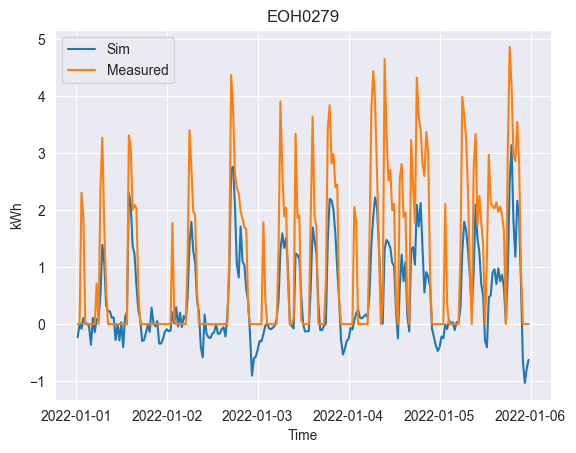

RMSE of q_hp: 1.2979342993441094


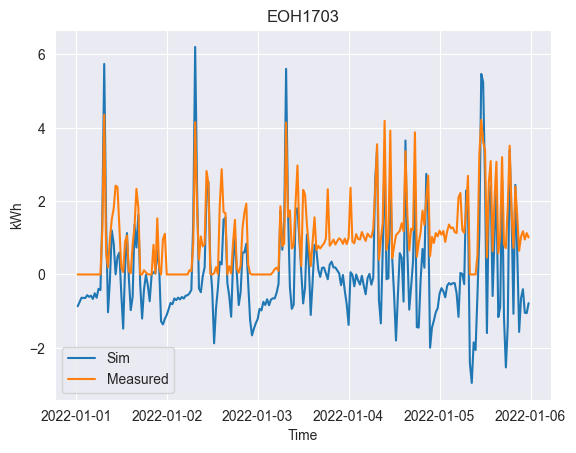

RMSE of q_hp: 1.1956639948601937


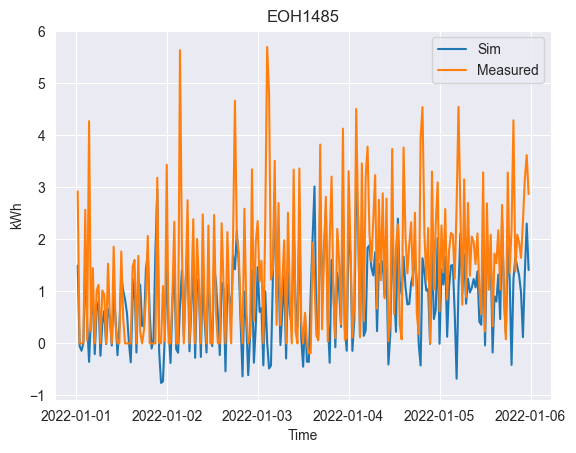

RMSE of q_hp: 1.0499072380494505


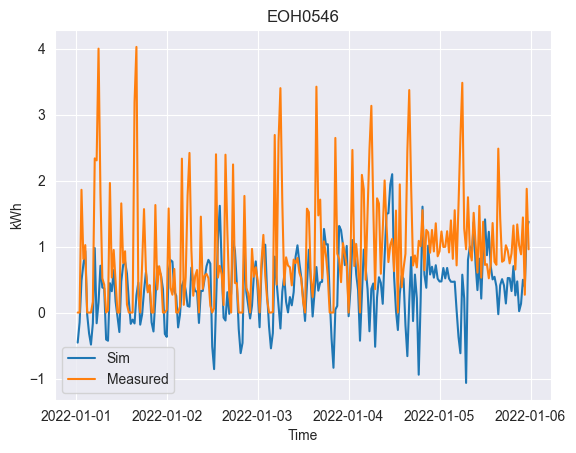

RMSE of q_hp: 1.7248754246460172


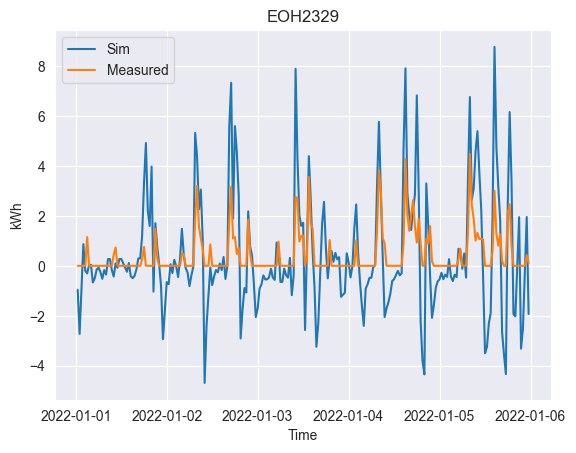

RMSE of q_hp: 2.021348831277298


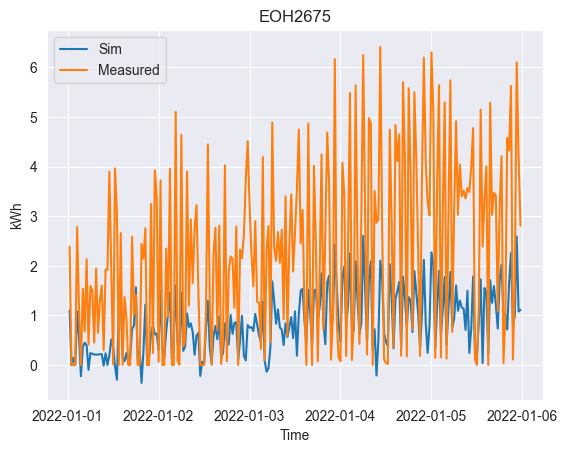

RMSE of q_hp: 1.4860845108571397


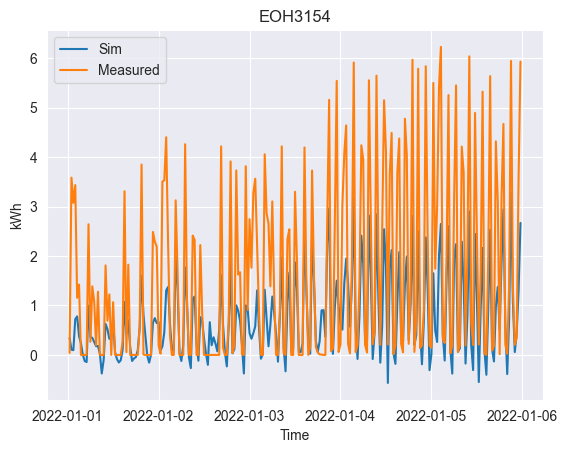

RMSE of q_hp: 1.5035459236050628


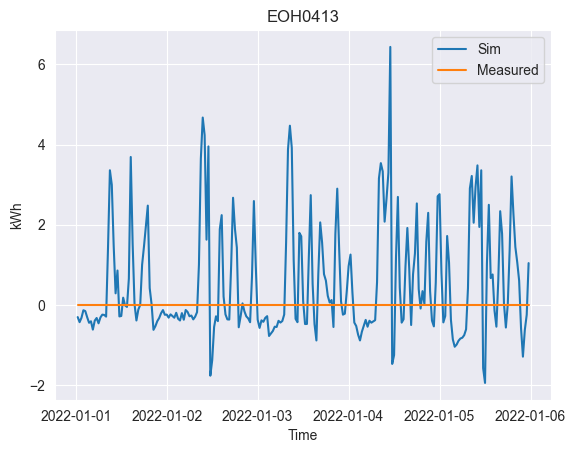

RMSE of q_hp: 1.4853650950153126


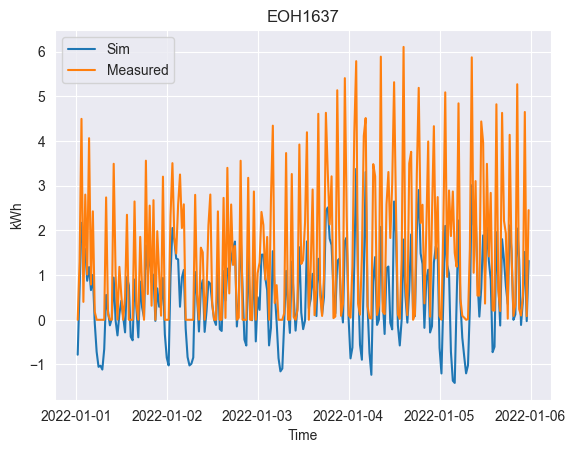

RMSE of q_hp: 1.0147208962475736


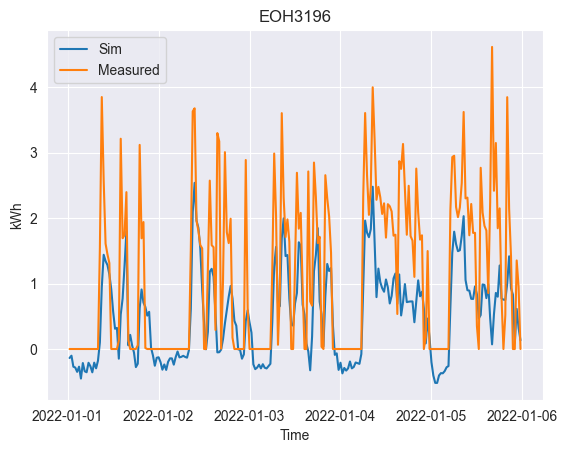

In [29]:
for id_use in unique_ids:
    df_id = trained_params[id_use].copy()
    C = df_id.C
    R_a = df_id.R_a
    w_s= df_id.w_s
    w = df_id.w
    
    
    df_single = df_train_detached[df_train_detached["Property_ID"] == id_use].copy()
    
    #re-adjust Heat Pump Diff and add temp differences
    df_single["Heat_Pump_Energy_Output_Diff"] = df_single["Heat_Pump_Energy_Output"].diff()
    df_single["Internal_Temperature_Diff"] = df_single["Internal_Air_Temperature"].diff()
    df_single["Internal_Ambient_Temperature_Diff"] = \
        (df_single["External_Air_Temperature"] - 
         df_single["Internal_Air_Temperature"])
         
    
    
    # 1. Drop columns with almost all missing data (e.g., more than 90% missing)
    threshold = 0.90 * len(df_single)
    df_single_cleaned = df_single.dropna(axis=1, thresh=threshold)
    #print("Columns dropped due to high missing values:")
    #print(df_single.columns.difference(df_single_cleaned.columns).tolist())
    
    df_single = df_single_cleaned
    
    #print("\nColumns remaining after dropping highly missing columns:")
    #print(df_single.columns.tolist())
    
    # 2. Handle missing values: Interpolate if missing for up to 2 hours (4 half-hour intervals), else drop rows
    df_single = df_single.set_index('Timestamp')
    df_single = df_single.sort_index()
    
    # Apply interpolation with a limit of 4 (for 2 hours of half-hourly data)
    numeric_cols = df_single.select_dtypes(include=['number']).columns
    df_single_numeric_interpolated = df_single[numeric_cols].interpolate(method='time', limit=4, limit_direction='both')
    
    df_single_interpolated = df_single.copy() 
    df_single_interpolated[numeric_cols] = df_single_numeric_interpolated
    
    # After interpolation, drop rows that still contain NaN values (meaning they were missing for > 2 hours)
    initial_rows = len(df_single_interpolated)
    df_single_processed = df_single_interpolated.dropna()
    rows_dropped_after_interpolation = initial_rows - len(df_single_processed)
    
    #print(f"\nNumber of rows dropped after handling NA values (missing for >
    # 2 hours): {rows_dropped_after_interpolation}")
    
    # -----EXTRACT SUMMER DATA -------# 
    df_heating_single = df_single_processed.copy()
    
    t_start = pd.to_datetime("2022 01 01 00:00:00")
    t_end = pd.to_datetime("2022 01 05 23:59:00")
    df_q_opt = df_q_results[(df_q_results.index>=t_start) & (df_q_results.index<=t_end)]
    df_heating_val = df_heating_single[df_heating_single.index>=t_start]
    df_heating_val = df_heating_val[df_heating_val.index<=t_end]
    
    
    
    T_a_val = (df_heating_val["External_Air_Temperature"].iloc[:-1].reset_index
           (drop=True).to_numpy()) 
    T_i_val = (df_heating_val["Internal_Air_Temperature"].iloc[:-1].reset_index
           (drop=True).to_numpy()) 
    delta_T_a_val = (df_heating_val["Internal_Ambient_Temperature_Diff"].iloc[:-1]
                 .reset_index(drop=True).to_numpy()) 
    delta_T_i_val = (df_heating_val["Internal_Temperature_Diff"].iloc[1:]
                 .reset_index(drop=True).to_numpy() / delta_t) 
    q_hp_val = (df_heating_val["Heat_Pump_Energy_Output_Diff"].iloc[:-1]
            .reset_index(drop=True).to_numpy()) 
    q_solar_val = (df_heating_val["SolarRadiation"].iloc[:-1].reset_index
               (drop=True).to_numpy()) 
    v_wind_val = (df_heating_val["Windspeed"].iloc[:-1].reset_index(drop=True)
              .to_numpy()) 
    
    
    
    q_hat_sim = (delta_T_i_val * C -  delta_T_a_val / R_a * delta_t  + w_s *  
            q_solar_val  + w * np.ones(len(T_a_val), )* delta_t )
    
    e_q = q_hat_sim - q_hp_val
    rmse_q_val = np.sqrt(np.mean(e_q**2))
    print(f"RMSE of q_hp: {rmse_q_val}")
    
    plt.plot(df_heating_val.index[1:],q_hat_sim, label = "Sim")
    plt.plot(df_heating_val.index[1:], q_hp_val, label = "Measured")
    plt.legend()
    plt.xlabel("Time")
    plt.ylabel("kWh")
    plt.title(f"{id_use}")
    plt.show()

In [30]:
'''

trained_params = pd.DataFrame(index = ["Floor Area","No_Storeys","Wall_Type",
                                       "C","R_a","w_s","w_w","w",
                                       "Q_hat","Q_sc","residuals", 
                                       "rmse_dTi","rmse_q_hp"])

for id_use in unique_ids:
    wall = df_house_train[id_use].Wall_Type.to_string()
    storeys = df_house_train[id_use].No_Storeys.to_string()
    floor_area = df_house_train[id_use].Total_Floor_Area.to_string()
    
    df_single = df_train_detached[df_train_detached["Property_ID"] == id_use].copy()
    
    #re-adjust Heat Pump Diff and add temp differences
    df_single["Heat_Pump_Energy_Output_Diff"] = df_single["Heat_Pump_Energy_Output"].diff()
    df_single["Internal_Temperature_Diff"] = df_single["Internal_Air_Temperature"].diff()
    df_single["Internal_Ambient_Temperature_Diff"] = \
        (df_single["External_Air_Temperature"] - 
         df_single["Internal_Air_Temperature"])
         
    
    
    # 1. Drop columns with almost all missing data (e.g., more than 90% missing)
    threshold = 0.90 * len(df_single)
    df_single_cleaned = df_single.dropna(axis=1, thresh=threshold)
    print("Columns dropped due to high missing values:")
    print(df_single.columns.difference(df_single_cleaned.columns).tolist())
    
    df_single = df_single_cleaned
    
    print("\nColumns remaining after dropping highly missing columns:")
    print(df_single.columns.tolist())
    
    # 2. Handle missing values: Interpolate if missing for up to 2 hours (4 half-hour intervals), else drop rows
    df_single = df_single.set_index('Timestamp')
    df_single = df_single.sort_index()
    
    # Apply interpolation with a limit of 4 (for 2 hours of half-hourly data)
    numeric_cols = df_single.select_dtypes(include=['number']).columns
    df_single_numeric_interpolated = df_single[numeric_cols].interpolate(method='time', limit=4, limit_direction='both')
    
    df_single_interpolated = df_single.copy() 
    df_single_interpolated[numeric_cols] = df_single_numeric_interpolated
    
    # After interpolation, drop rows that still contain NaN values (meaning they were missing for > 2 hours)
    initial_rows = len(df_single_interpolated)
    df_single_processed = df_single_interpolated.dropna()
    rows_dropped_after_interpolation = initial_rows - len(df_single_processed)
    
    print(f"\nNumber of rows dropped after handling NA values (missing for > 2 hours): {rows_dropped_after_interpolation}")
    
    # Less than 18 C
    df_heating_single = df_single_processed.copy()
    #df_heating_single = [df_single_processed["External_Air_Temperature"]<=18]
    
    
    #time range
    t_start = pd.to_datetime("2022 01 01 00:00:00")
    t_end = pd.to_datetime("2022 12 31 23:59:00")
    df_heating_annual = df_heating_single[df_heating_single.index>=t_start]
    df_heating_annual = df_heating_annual[df_heating_annual.index<=t_end]
    
    t_step = 30 # minutes
    delta_t = t_step/60
    
    T_a = (df_heating_annual["External_Air_Temperature"].iloc[:-1].reset_index
           (drop=True).to_numpy()) 
    T_i = (df_heating_annual["Internal_Air_Temperature"].iloc[:-1].reset_index
           (drop=True).to_numpy()) 
    delta_T_a = (df_heating_annual["Internal_Ambient_Temperature_Diff"].iloc[:-1]
                 .reset_index(drop=True).to_numpy()) 
    delta_T_i = (df_heating_annual["Internal_Temperature_Diff"].iloc[1:]
                 .reset_index(drop=True).to_numpy() / delta_t) 
    q_hp = (df_heating_annual["Heat_Pump_Energy_Output_Diff"].iloc[:-1]
            .reset_index(drop=True).to_numpy()) 
    q_solar = (df_heating_annual["SolarRadiation"].iloc[:-1].reset_index
               (drop=True).to_numpy()) 
    v_wind = (df_heating_annual["Windspeed"].iloc[:-1].reset_index(drop=True)
              .to_numpy()) 
    
    # solves with error terms around dT_i and q_hp
    
    N = len(delta_T_i)
    
    Q_DHW = df_house_train[id_use].MCS_DHWAnnual.to_numpy()
    q_max = df_house_train[id_use].HP_Size_kW.to_numpy()
    
    # Total heating energy (space conditioning) minus DHW
    Q_sc = np.sum(q_hp) - Q_DHW  # in kWh
    
    # Known parameter
    C = 7
    phi_e = 0.1
    phi_z = 0.001
    phi_w = 2
    phi_u = 2000
    phi = 5
    # CVXPY variables
    a = cp.Variable(pos=True)  #  a = 1/(R_a*C)
    w_s = cp.Variable(nonneg=True)
    w_w = cp.Variable(nonneg=True)
    w = cp.Variable()
    e = cp.Variable()
    z = cp.Variable(N, nonneg=True)
    u = cp.Variable(N)
    q_hat = cp.Variable(N)
    
    # Constraint: temperature dynamics match model
    model_rhs = (delta_T_a * a + q_hat + w_s * q_solar * T_a + w_w *
                 delta_T_a @ v_wind.T + w * np.ones(N, )) / C
    
    constraints = [
        cp.sum(q_hat) - Q_sc == e,
        delta_T_i + u == model_rhs,
        q_hat >= np.zeros(N, ),
        q_hat <= q_hp*delta_t + z,
        q_hat <= q_max*delta_t,
        a >= 1/25
        #w_s <= 3
    ]
    
    # Objective: minimize squared error on energy balance
    objective = cp.Minimize(
        phi_e * e ** 2
        + phi_z * cp.norm2(z)
        + phi_u * cp.norm2(u)
        #+ phi_w*w_w
        #+ phi * w 
    )  #+ cp.norm2(z))
    
    # Solve
    prob = cp.Problem(objective, constraints)
    result = prob.solve(solver=cp.GUROBI, verbose=False)
    R_a = 1 / a
    
    rmse_dTi = np.sqrt(np.mean(u.value ** 2))
    rmse_q_hp = np.sqrt(np.mean(z.value ** 2))
    
    # Output
    print("Optimal R_a:", R_a.value)
    print("w_s (solar gain):", w_s.value)
    print("w_w (wind effect):", w_w.value)
    print("w (bias):", w.value)
    print("Q_hat total:", np.sum(q_hat.value))
    print("Q_sc:", Q_sc)
    print("Residual (e):", e.value)
    print("RMSE dTi:", rmse_dTi)
    print("RMSE q_hat:", rmse_q_hp)
    
    trained_params[id_use]= [floor_area, storeys, wall, C,R_a.value,w_s
    .value,w_w.value,w.value,np.sum(q_hat.value),Q_sc,e.value,
                                rmse_dTi, rmse_q_hp] 
'''

'\n\ntrained_params = pd.DataFrame(index = ["Floor Area","No_Storeys","Wall_Type",\n                                       "C","R_a","w_s","w_w","w",\n                                       "Q_hat","Q_sc","residuals", \n                                       "rmse_dTi","rmse_q_hp"])\n\nfor id_use in unique_ids:\n    wall = df_house_train[id_use].Wall_Type.to_string()\n    storeys = df_house_train[id_use].No_Storeys.to_string()\n    floor_area = df_house_train[id_use].Total_Floor_Area.to_string()\n\n    df_single = df_train_detached[df_train_detached["Property_ID"] == id_use].copy()\n\n    #re-adjust Heat Pump Diff and add temp differences\n    df_single["Heat_Pump_Energy_Output_Diff"] = df_single["Heat_Pump_Energy_Output"].diff()\n    df_single["Internal_Temperature_Diff"] = df_single["Internal_Air_Temperature"].diff()\n    df_single["Internal_Ambient_Temperature_Diff"] =         (df_single["External_Air_Temperature"] - \n         df_single["Internal_Air_Temperature"])\n\n\n\n    # 1. 

In [31]:
df_heating_single

,Property_ID,half-hour,Circulation_Pump_Energy_Consumed,Heat_Pump_Energy_Output,Whole_System_Energy_Consumed,External_Air_Temperature,Heat_Pump_Heating_Flow_Temperature,Heat_Pump_Return_Temperature,Internal_Air_Temperature,Hot_Water_Flow_Temperature,...,Temperature,FeelsLike,Humidity,Dew,Precipitation,SolarRadiation,SolarEnergy,Windspeed,Internal_Temperature_Diff,Internal_Ambient_Temperature_Diff
Timestamp,,,,,,,,,,,,,,,,,,,,,
2020-11-27 14:00:00,EOH3196,14:00:00,0.000,0.000,0.009,6.97,24.78,28.03,13.32,22.36,...,7.40,6.80,70.740,2.40,0.000,58.0,0.20,5.10,-0.84,-6.35
2020-11-27 14:30:00,EOH3196,14:30:00,0.000,0.000,0.009,6.93,24.78,39.39,12.48,34.54,...,7.10,6.80,72.785,2.55,0.000,49.5,0.15,3.75,-0.84,-5.55
2020-11-27 15:00:00,EOH3196,15:00:00,0.000,0.000,0.009,6.69,24.78,35.09,12.89,28.59,...,6.80,6.80,74.830,2.70,0.000,41.0,0.10,2.40,0.41,-6.20
2020-11-27 15:30:00,EOH3196,15:30:00,0.000,0.000,0.009,6.24,24.78,52.10,13.01,46.58,...,6.35,6.35,77.570,2.75,0.000,23.5,0.05,2.75,0.12,-6.77
2020-11-27 16:00:00,EOH3196,16:00:00,0.000,0.000,0.009,6.00,24.78,28.36,13.08,23.95,...,5.90,5.90,80.310,2.80,0.000,6.0,0.00,3.10,0.07,-7.08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-28 22:00:00,EOH3196,22:00:00,62.837,23051.352,6703.255,13.39,26.86,27.26,20.53,59.57,...,14.70,14.70,77.430,10.80,0.034,0.0,0.00,20.30,-0.04,-7.14
2023-09-28 22:30:00,EOH3196,22:30:00,62.837,23051.352,6703.266,13.08,26.13,26.44,20.43,59.57,...,14.20,14.20,82.725,11.25,0.248,0.0,0.00,19.95,-0.10,-7.35
2023-09-28 23:00:00,EOH3196,23:00:00,62.837,23051.352,6703.275,12.77,25.50,25.73,20.36,59.57,...,13.70,13.70,88.020,11.70,0.462,0.0,0.00,19.60,-0.07,-7.59


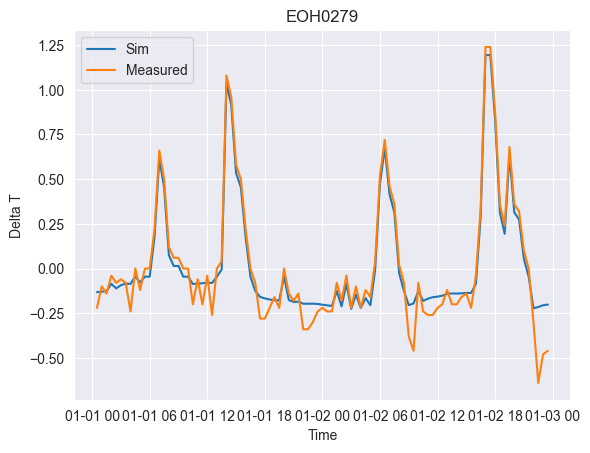

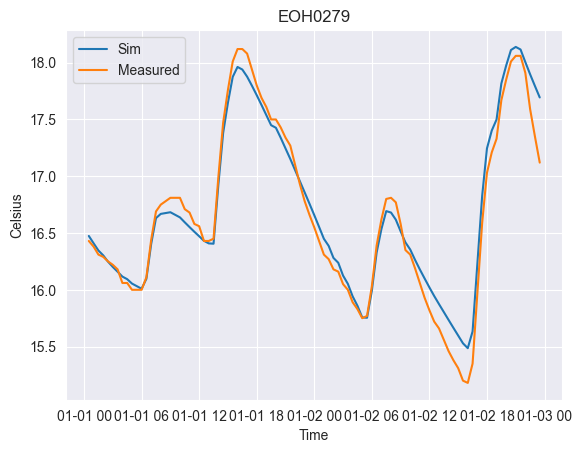

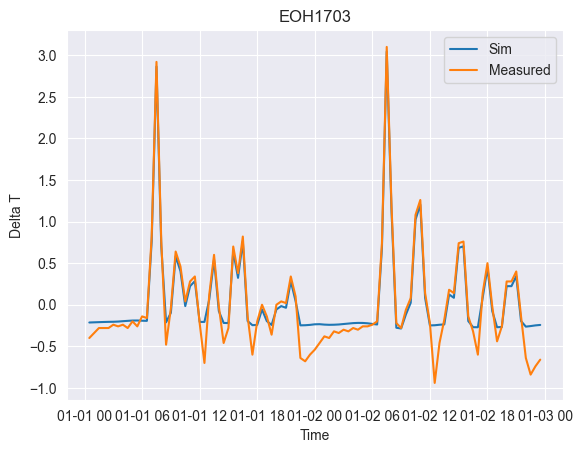

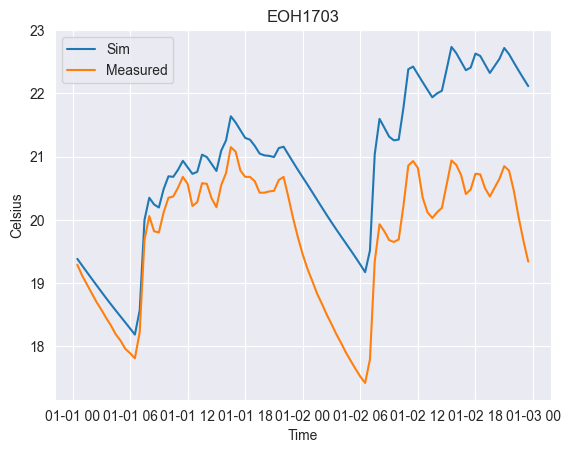

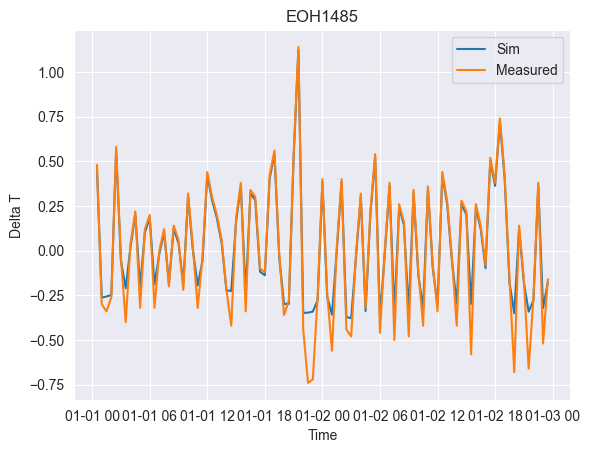

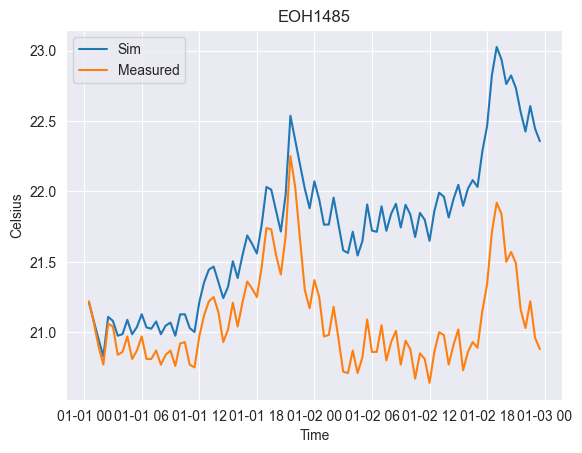

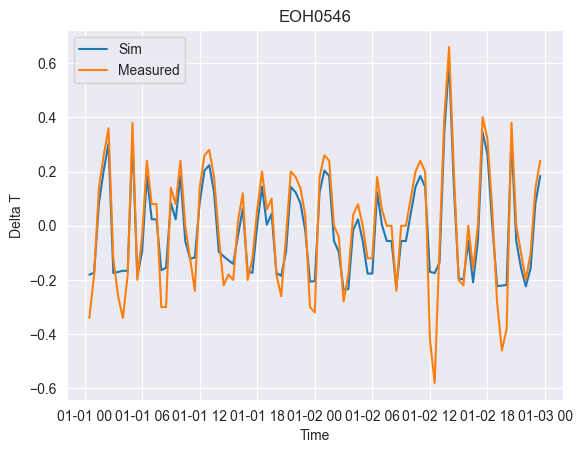

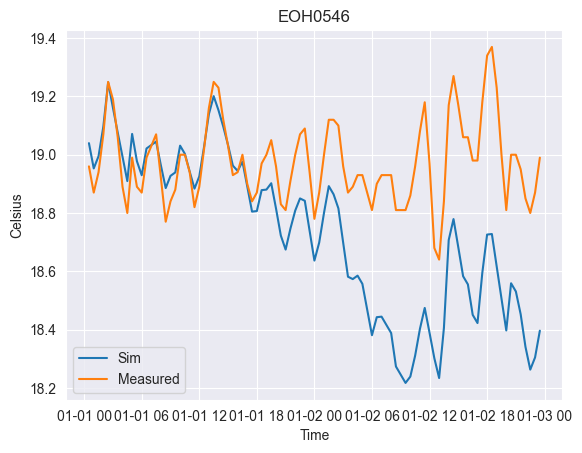

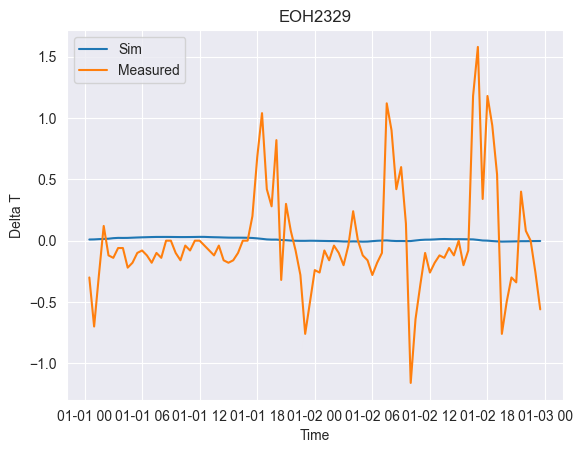

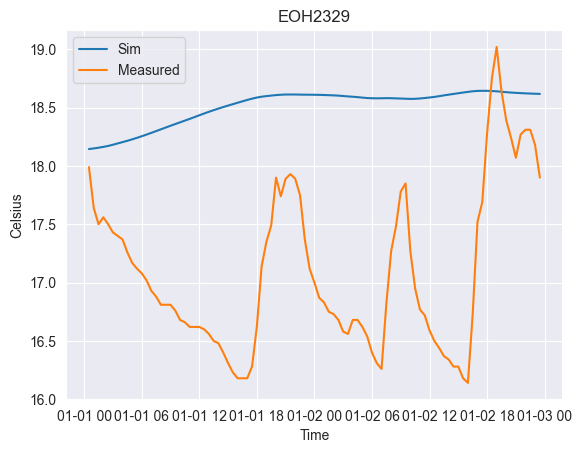

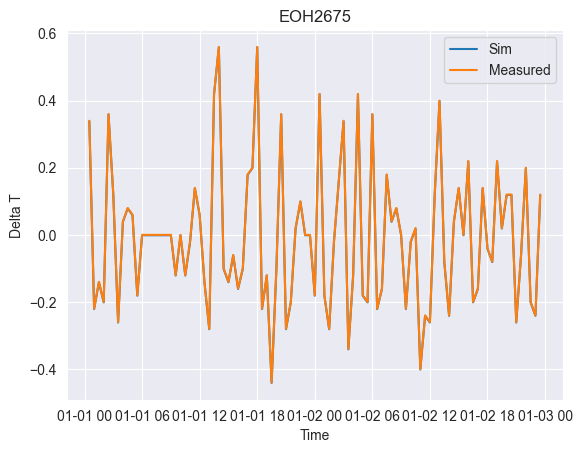

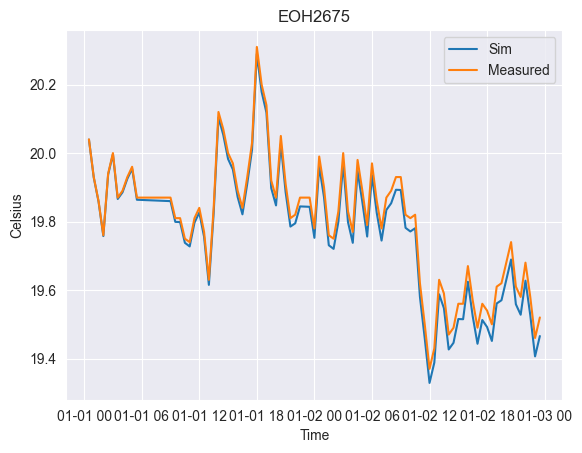

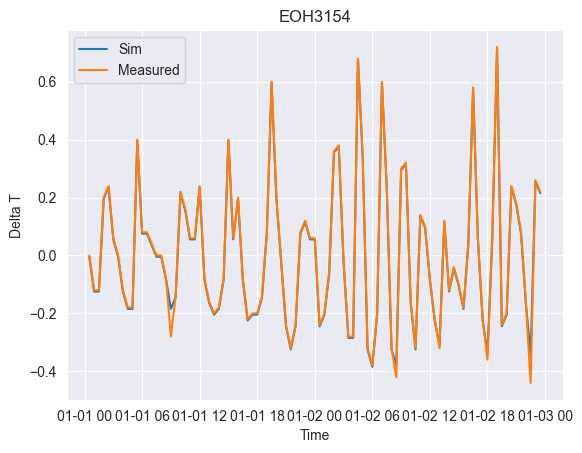

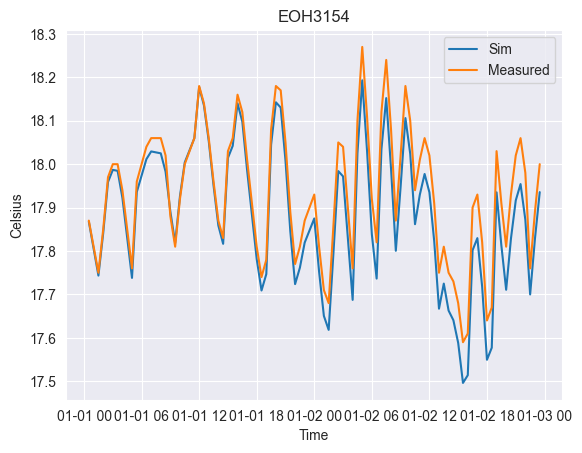

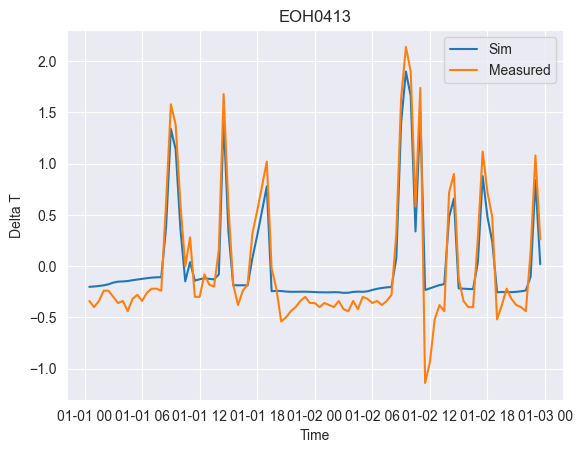

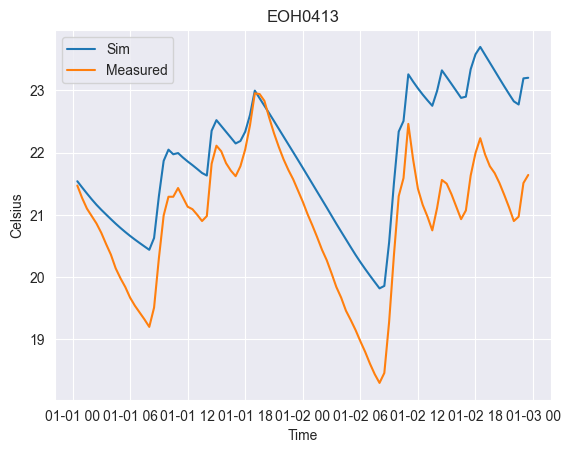

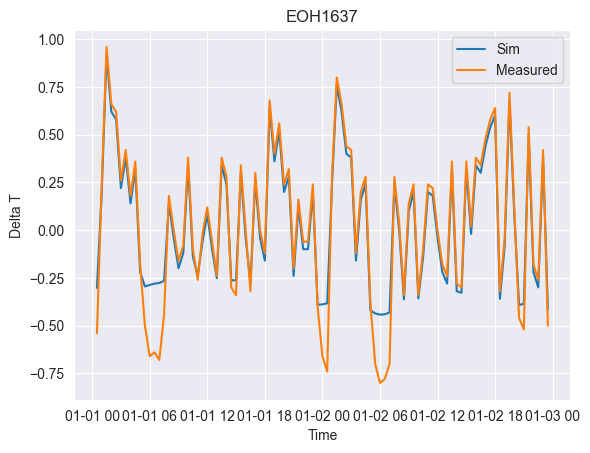

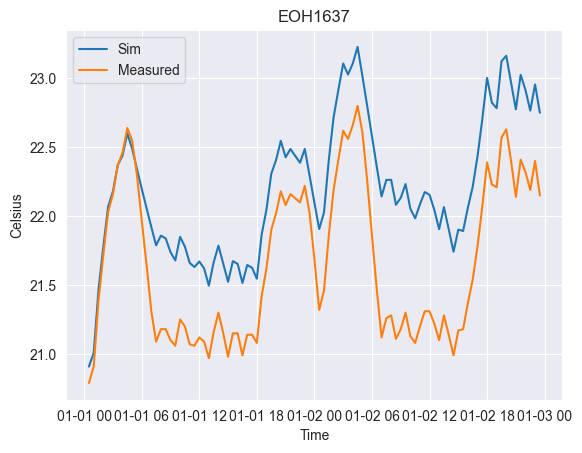

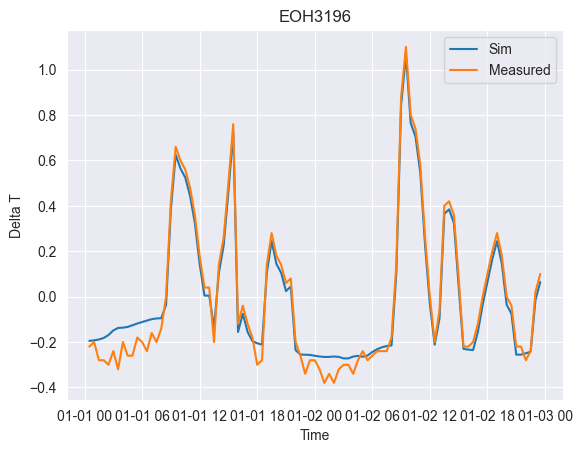

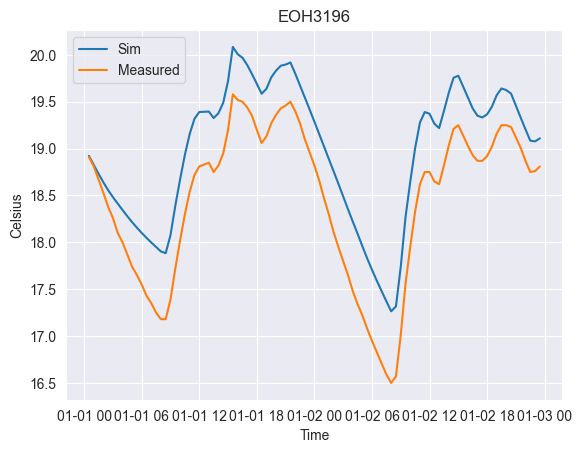

In [32]:
for id_use in unique_ids:
    df_id = trained_params[id_use].copy()
    C = df_id.C
    R_a = df_id.R_a
    w_s= df_id.w_s
    w = df_id.w
    
    df_single = df_train_detached[df_train_detached["Property_ID"] == id_use].copy()
    
    #re-adjust Heat Pump Diff and add temp differences
    df_single["Heat_Pump_Energy_Output_Diff"] = df_single["Heat_Pump_Energy_Output"].diff()
    df_single["Internal_Temperature_Diff"] = df_single["Internal_Air_Temperature"].diff()
    df_single["Internal_Ambient_Temperature_Diff"] = \
        (df_single["External_Air_Temperature"] - 
         df_single["Internal_Air_Temperature"])
         
    
    
    # 1. Drop columns with almost all missing data (e.g., more than 90% missing)
    threshold = 0.90 * len(df_single)
    df_single_cleaned = df_single.dropna(axis=1, thresh=threshold)
    #print("Columns dropped due to high missing values:")
    #print(df_single.columns.difference(df_single_cleaned.columns).tolist())
    
    df_single = df_single_cleaned
    
    #print("\nColumns remaining after dropping highly missing columns:")
    #print(df_single.columns.tolist())
    
    # 2. Handle missing values: Interpolate if missing for up to 2 hours (4 half-hour intervals), else drop rows
    df_single = df_single.set_index('Timestamp')
    df_single = df_single.sort_index()
    
    # Apply interpolation with a limit of 4 (for 2 hours of half-hourly data)
    numeric_cols = df_single.select_dtypes(include=['number']).columns
    df_single_numeric_interpolated = df_single[numeric_cols].interpolate(method='time', limit=4, limit_direction='both')
    
    df_single_interpolated = df_single.copy() 
    df_single_interpolated[numeric_cols] = df_single_numeric_interpolated
    
    # After interpolation, drop rows that still contain NaN values (meaning they were missing for > 2 hours)
    initial_rows = len(df_single_interpolated)
    df_single_processed = df_single_interpolated.dropna()
    rows_dropped_after_interpolation = initial_rows - len(df_single_processed)
    
    #print(f"\nNumber of rows dropped after handling NA values (missing for >
    # 2 hours): {rows_dropped_after_interpolation}")
    
    # -----EXTRACT SUMMER DATA -------# 
    df_heating_single = df_single_processed.copy()
    
    # Validate results
    t_start = pd.to_datetime("2022 01 01 00:00:00")
    t_end = pd.to_datetime("2022 01 02 23:59:00")
    df_q_id_use = df_q_id[(df_q_id.index>=t_start) & (df_q_id.index<=t_end)]
    df_heating_val = df_heating_single[df_heating_single.index>=t_start]
    df_heating_val = df_heating_val[df_heating_val.index<=t_end]
    
    
    
    T_a_val = (df_heating_val["External_Air_Temperature"].iloc[:-1].reset_index
           (drop=True).to_numpy()) 
    T_i_val = (df_heating_val["Internal_Air_Temperature"].iloc[:-1].reset_index
           (drop=True).to_numpy()) 
    delta_T_a_val = (df_heating_val["Internal_Ambient_Temperature_Diff"].iloc[:-1]
                 .reset_index(drop=True).to_numpy()) 
    delta_T_i_val = (df_heating_val["Internal_Temperature_Diff"].iloc[1:]
                 .reset_index(drop=True).to_numpy() / delta_t) 
    q_hp_val = (df_heating_val["Heat_Pump_Energy_Output_Diff"].iloc[:-1]
            .reset_index(drop=True).to_numpy()) 
    q_opt = df_q_id_use[id_use].iloc[:-1].reset_index(drop=True).to_numpy()
    q_solar_val = (df_heating_val["SolarRadiation"].iloc[:-1].reset_index
               (drop=True).to_numpy()) 
    v_wind_val = (df_heating_val["Windspeed"].iloc[:-1].reset_index(drop=True)
              .to_numpy()) 
    
    
    delta_T_i_sim = (delta_T_a_val / R_a *delta_t + q_opt + w_s* q_solar_val + w
                     * np
                     .ones(len(T_a_val), )* delta_t) / C
    
    T_i_sim = np.zeros_like(T_i_val)
    T_i_prev = T_i_val[0]
    for i in range(len(delta_T_i_sim)):
        T_i_sim[i] = T_i_prev + delta_T_i_sim[i]*delta_t
        T_i_prev = T_i_sim[i]
    
    
    plt.plot(df_heating_val.index[1:],delta_T_i_sim, label = "Sim")
    plt.plot(df_heating_val.index[1:], delta_T_i_val, label = "Measured")
    plt.legend()
    plt.xlabel("Time")
    plt.ylabel("Delta T")
    plt.title(f"{id_use}")
    plt.show()
    
    plt.plot(df_heating_val.index[1:],T_i_sim, label = "Sim")
    plt.plot(df_heating_val.index[1:], df_heating_val["Internal_Air_Temperature"]
             .iloc[1:].reset_index
           (drop=True).to_numpy(), label = "Measured")
    plt.legend()
    plt.xlabel("Time")
    plt.ylabel("Celsius")
    plt.title(f"{id_use}")
    plt.show()